In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpl 
import seaborn as sns
import sklearn as sk

data = pd.read_csv('Dataset.csv')

### Basic data exploration

In [26]:
data.info()

print('\nPercentage of data missing: \n')
perc_null = data.isnull().sum() / data.count() * 100
print(perc_null.map('{:,.2f}%'.format))

print(f'\nNumber of exact duplicates: {data.duplicated().sum()}')

# DateTime STR -> DT, use as index
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.set_index('DateTime')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DateTime                1607 non-null   object 
 1   Market1: Close          1555 non-null   float64
 2   Market1: High           1555 non-null   float64
 3   Market1: Low            1555 non-null   float64
 4   Market1: Open           1555 non-null   float64
 5   Market2: Close          1563 non-null   float64
 6   Market2: High           1563 non-null   float64
 7   Market2: Low            1563 non-null   float64
 8   Market2: Open           1563 non-null   float64
 9   Market2: Open_Interest  1548 non-null   float64
 10  Market2: Volume         1563 non-null   float64
 11  Market3: Close          1503 non-null   float64
 12  Market3: High           1503 non-null   float64
 13  Market3: Low            1503 non-null   float64
 14  Market3: Open           1502 non-null   

#### Observations:
- OHLC, Volume, OI data for three separate instruments
- Amount of missing values are in an acceptable range (< 20%)
- No duplicates

### Markets corellation investigation
(Multivariate analysis)

               Market1: Open  Market2: Open  Market3: Open
Market1: Open       1.000000       0.998509       0.956825
Market2: Open       0.998509       1.000000       0.963319
Market3: Open       0.956825       0.963319       1.000000 



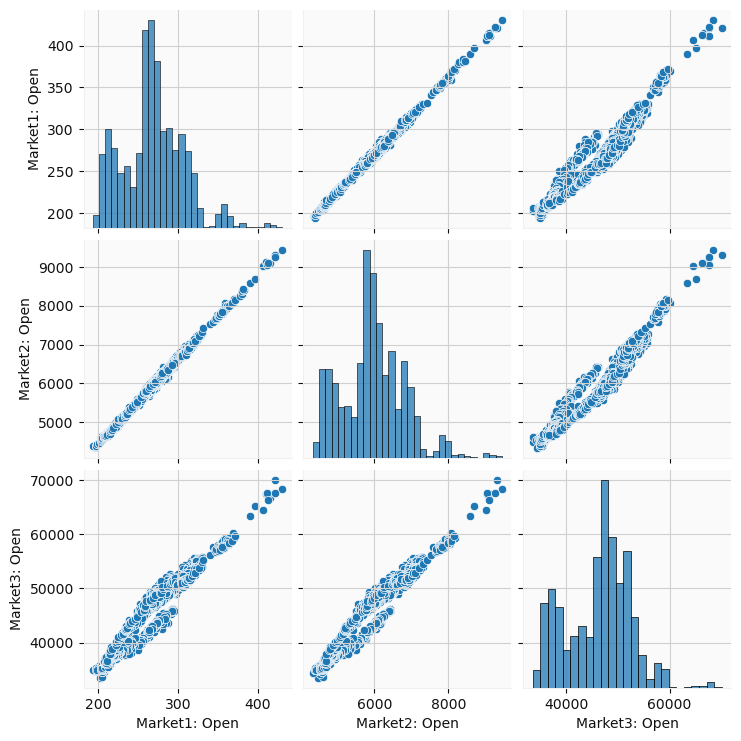

                        Market2: Volume  Market2: Open_Interest  \
Market2: Volume                1.000000                0.153844   
Market2: Open_Interest         0.153844                1.000000   
Market3: Volume                0.449824                0.306807   
Market3: Open_Interest         0.348018                0.243507   

                        Market3: Volume  Market3: Open_Interest  
Market2: Volume                0.449824                0.348018  
Market2: Open_Interest         0.306807                0.243507  
Market3: Volume                1.000000                0.435458  
Market3: Open_Interest         0.435458                1.000000  


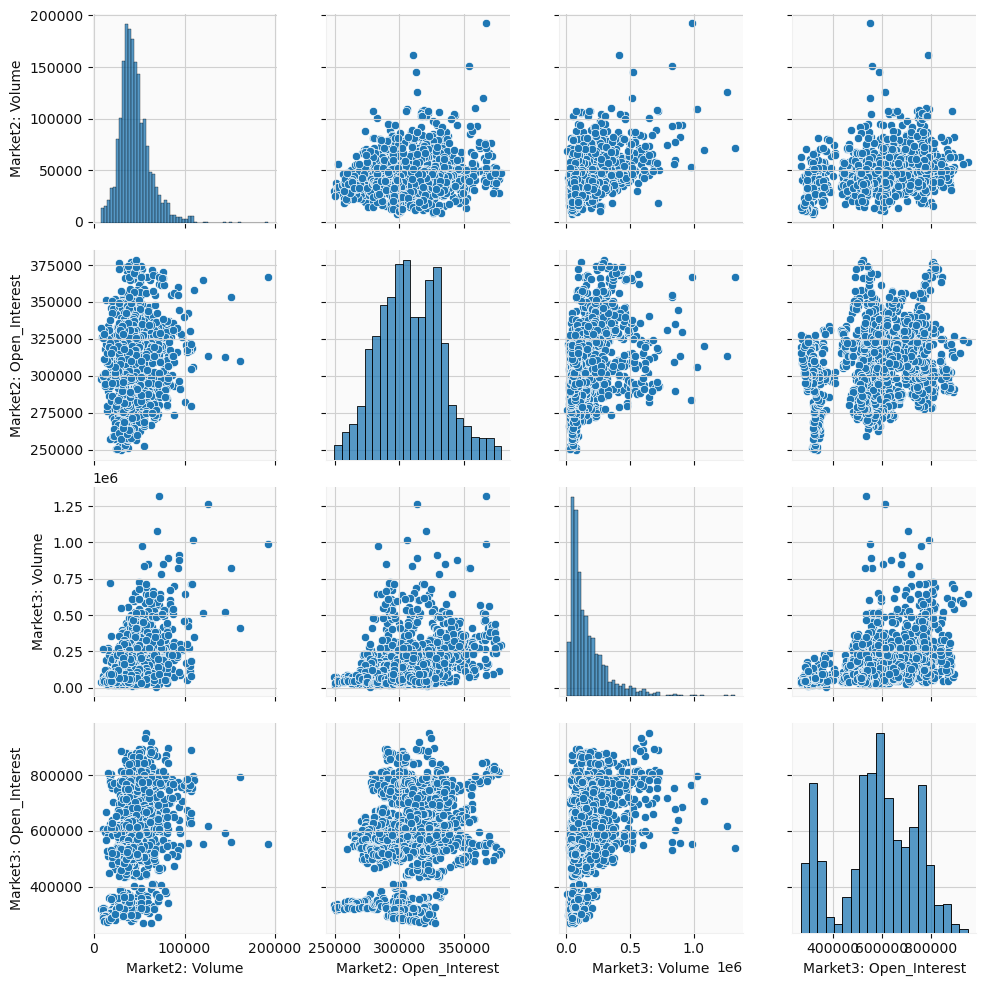

In [27]:
market_closes = ['Market1: Open', 'Market2: Open', 'Market3: Open']
closes_only = data.loc[:, market_closes]
print(closes_only.corr(method='pearson'), '\n')

sns.pairplot(closes_only)
plt.show()

market_vols = ['Market2: Volume', 'Market2: Open_Interest',
                 'Market3: Volume', 'Market3: Open_Interest']
volumes_only = data.loc[:, market_vols]
print(volumes_only.corr(method='pearson'))

sns.pairplot(volumes_only)
plt.show()

#### Observations:
- Prices are highly correlated (close to perfect), mainly M1 M2
- Volumes / OI are very loosely correlated
- Assuming we are dealing with derivatives of same underlying asset or synthetic data

### Visualization of price

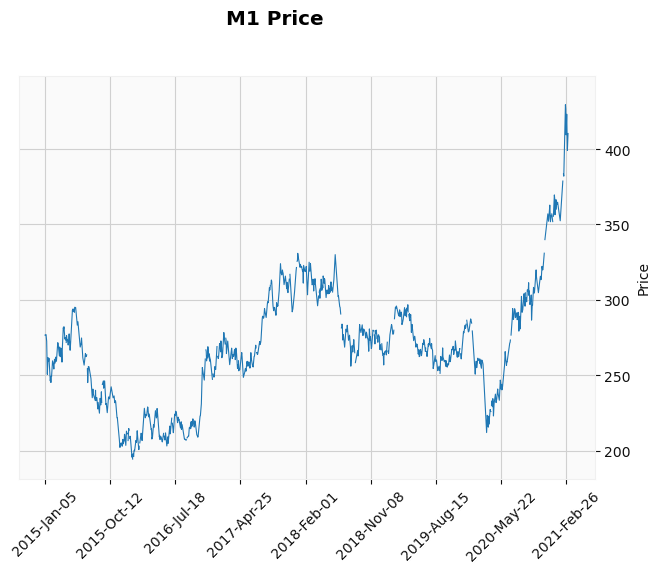

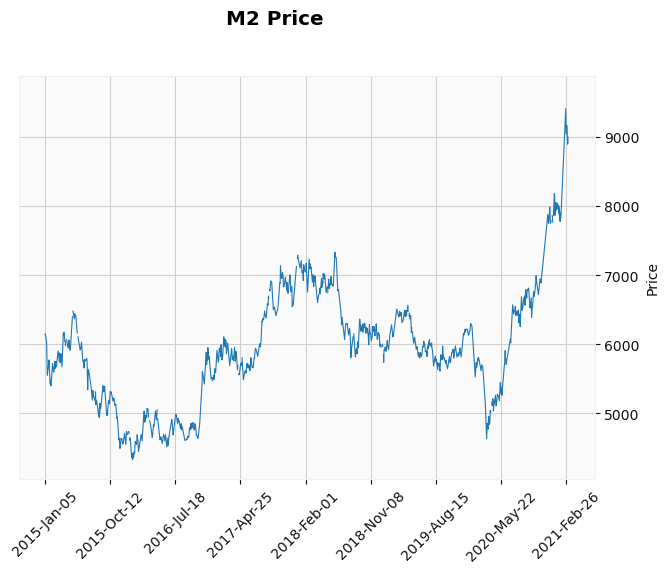

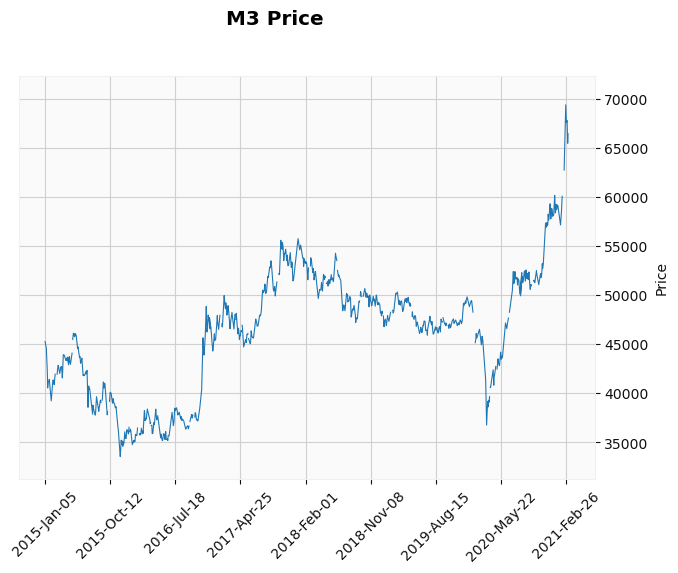

In [28]:
for i in range(3):
    cols = [f'Market{i+1}: Close',
            f'Market{i+1}: High',
            f'Market{i+1}: Low',
            f'Market{i+1}: Open']
    
    market = data.loc[:, cols]
    market.columns = ['Close', 'High', 'Low', 'Open']

    mpl.plot(market, type="line", title = f"M{i+1} Price",  
             style="yahoo")

In [2]:
# Investigate a possible data gaps overlap
def days_missing(df):
    cols = np.zeros((3, 4), dtype=object)
    for i in range(3):
        cols[i] = [f'Market{i+1}: Close',
                   f'Market{i+1}: High',
                   f'Market{i+1}: Low',
                   f'Market{i+1}: Open']
    cols = cols.T   

    print('N of O/H/L/C datapoins missing for all markets simultaneously:')
    for c in cols:
        print(df[c].isnull().all(axis=1).sum())
        
days_missing(data)        

N of O/H/L/C datapoins missing for all markets simultaneously:
3
3
3
3


#### Observations:
- No obvious outliers, errors
- Price gaps are seeminly not overlapping across the markets, but there is a few entirely missing days (3)
- We can strongly assume it is the same asset, but different instrument on different exchange/broker
- We can easily amputate the missing values by appropriately scaling the price of different, most corellated market

### OHLC missing values amputation
(sklearn.impute.IterativeImputer has proven problematic, thus custom approach (alternatively could train linear model, should be equivalent))

In [4]:
def fill_OHLC_gap(df, n_markets=3):
    data = df.copy()
    correlations = data.corr(method='pearson')
    
    # Create np.array where each row will correspond to O/H/L/C column name for
    # each of markets
    ohlc_cols = np.zeros((3, 4), dtype=object)
    for i in range(3):
        ohlc_cols[i] = [f'Market{i+1}: Close',
                        f'Market{i+1}: High',
                        f'Market{i+1}: Low',
                        f'Market{i+1}: Open']
    ohlc_cols = ohlc_cols.T

    for pricepoint in ohlc_cols:             # For Highs, Lows, Opens, Closes
        for market in pricepoint:            # For each market's O/H/L/C
            if data[market].isnull().any():  # If has NULLs
                
                # Find the best correlated market to currently iterated
                idx = pd.Index(pricepoint)
                idx_excluded = idx.difference(pd.Index([market]))
                market_match = correlations.loc[idx_excluded, market].idxmax()
                
                # Determine the ratio of the columns, replace NULLs
                def replace_missing(col1, col2):
                    ratio = (col1 / col2).mean()
                    idx_nulls = col1.isnull()
                    col1.loc[idx_nulls] = col2.loc[idx_nulls] * ratio
                
                replace_missing(data.loc[:, market], data.loc[:, market_match])
                
                # If still missing, try to use thrid market's data
                if data[market].isnull().any():
                    market2 = pricepoint[(pricepoint!=market) & (pricepoint!=market_match)]
                    replace_missing(data.loc[:, market], data.loc[:, market2[0]])
                    
    return data

DateTime                    0
Market1: Close              3
Market1: High               3
Market1: Low                3
Market1: Open               3
Market2: Close              3
Market2: High               3
Market2: Low                3
Market2: Open               3
Market2: Open_Interest     59
Market2: Volume            44
Market3: Close              3
Market3: High               3
Market3: Low                3
Market3: Open               3
Market3: Open_Interest    104
Market3: Volume           104
dtype: int64

### Volume / Open Interest values amputation
By looking at ACF we can quickly judge what type of model is suitable for predict the missing values

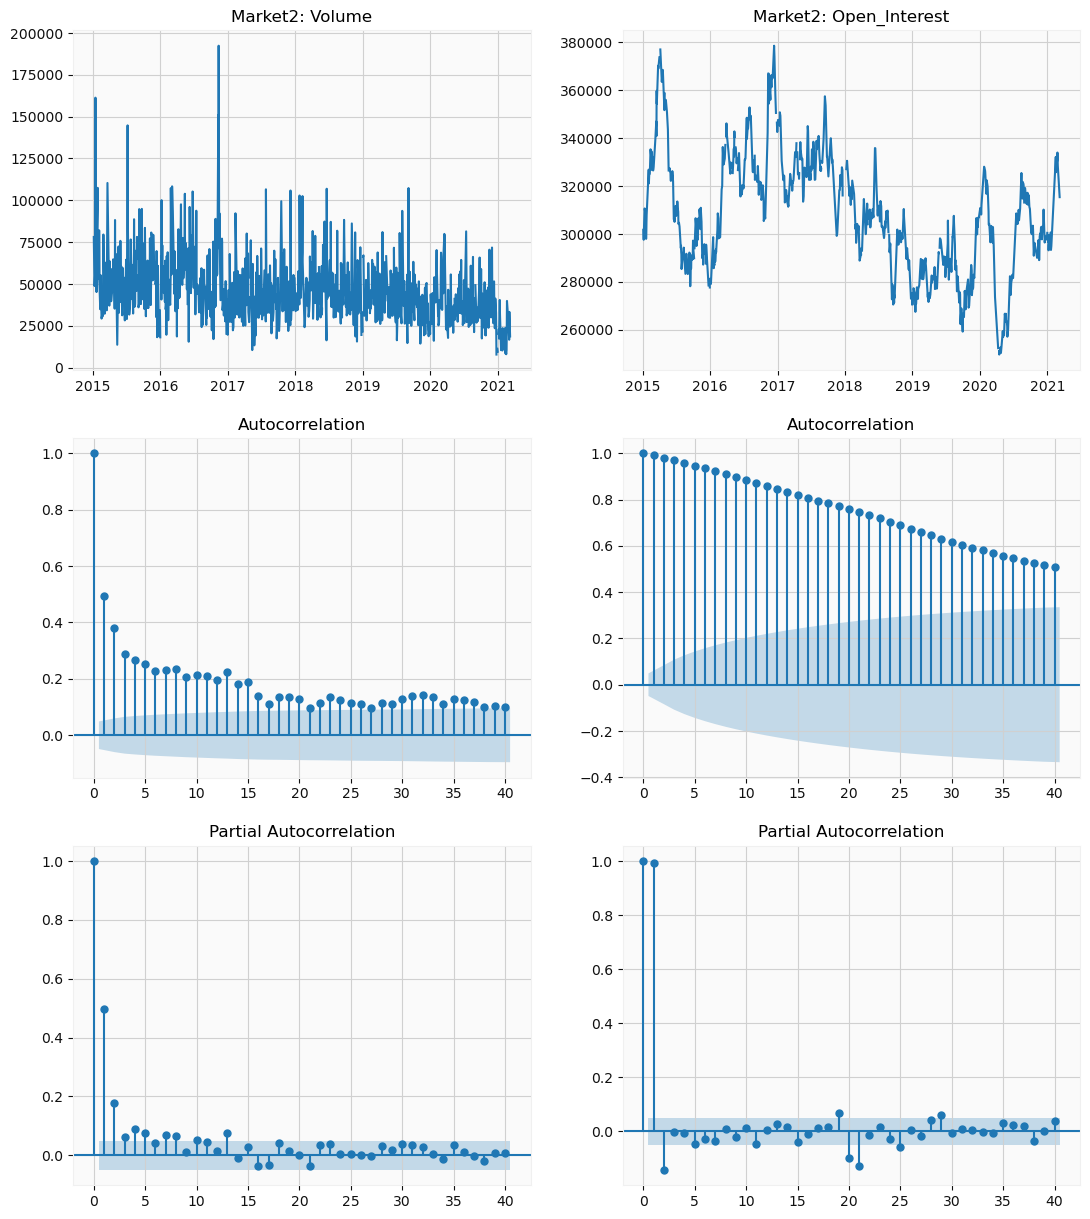

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plt_ts_corr(col1, col2):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(13, 15))
    ax[0][0].plot(col1)
    ax[0][0].set_title(col1.name)
    ax[0][1].plot(col2)
    ax[0][1].set_title(col2.name)

    plot_acf(col1.to_numpy(), missing='drop', lags=40, ax=ax[1][0])
    plot_acf(col2.to_numpy(), missing='drop', lags=40, ax=ax[1][1])
    plot_pacf(col1.dropna().to_numpy(), method="ldadjusted", lags=40, ax=ax[2][0])
    plot_pacf(col2.dropna().to_numpy(), method="ldadjusted", lags=40, ax=ax[2][1])
    plt.show()
    
plt_ts_corr(data_filled['Market2: Volume'],data_filled['Market2: Open_Interest'])    

#### Observations:
- Volume (ARMA process), OI (primarely AR process)
- Both series are non-stationary, Volume slighty, OI highly.
- Due to this we should use differentiation in our model (ARIMA)
- Wide time range of data (years) and type of data suggests we should account for seasonality (SARIMA)

We will take a look at the same plots after single differencing

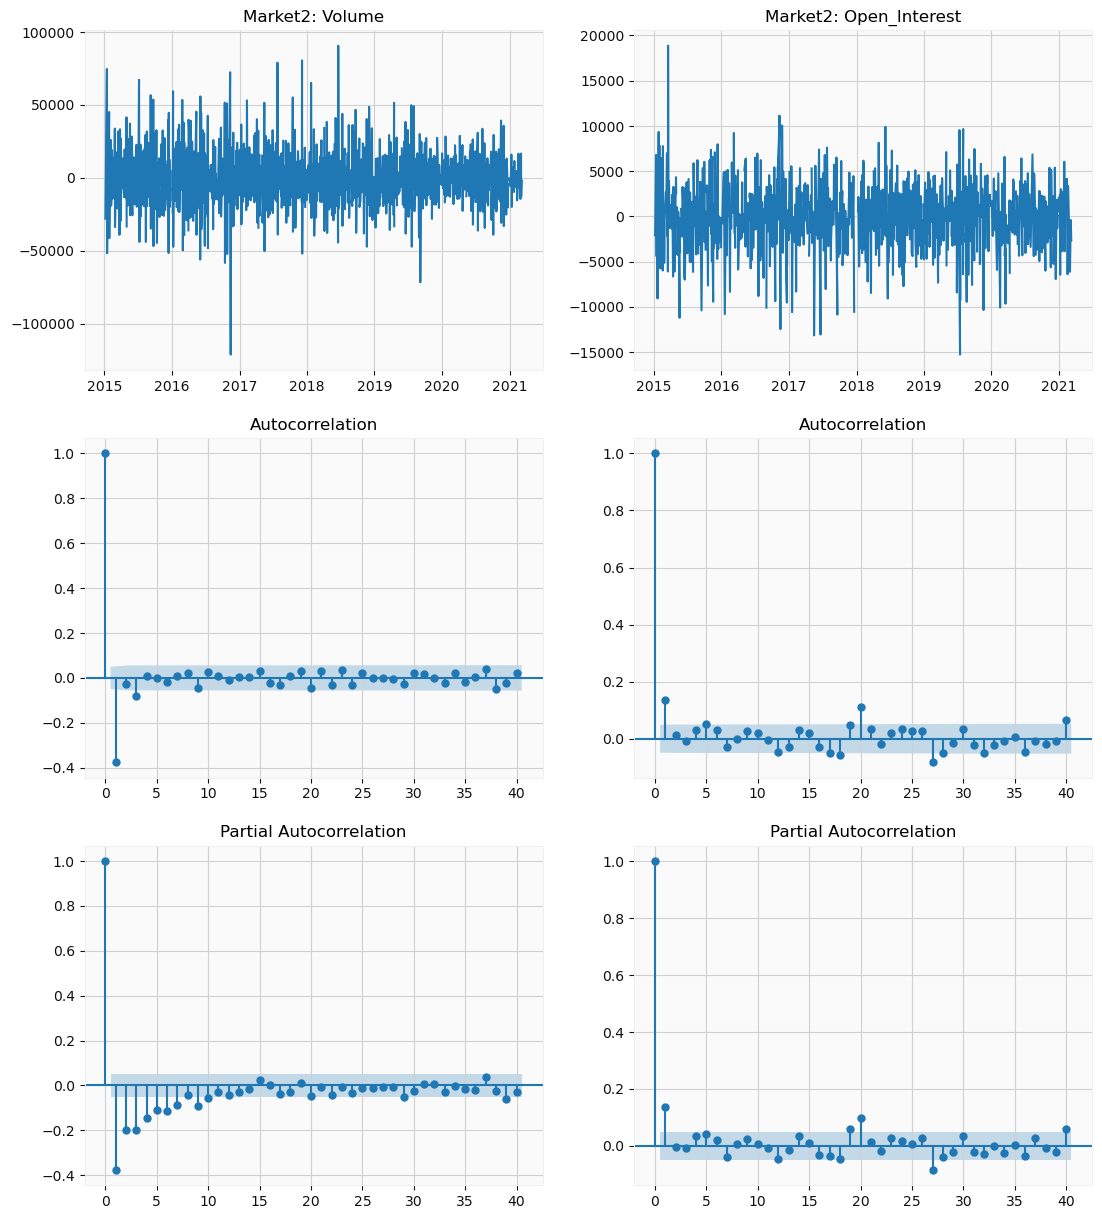

In [32]:
plt_ts_corr(data_filled['Market2: Volume'].diff(),
            data_filled['Market2: Open_Interest'].diff()) 

#### Observations
- d=1 differencing is more than enought
- Volume may be slighly overdifferenced (can be compensated by extra MA term)

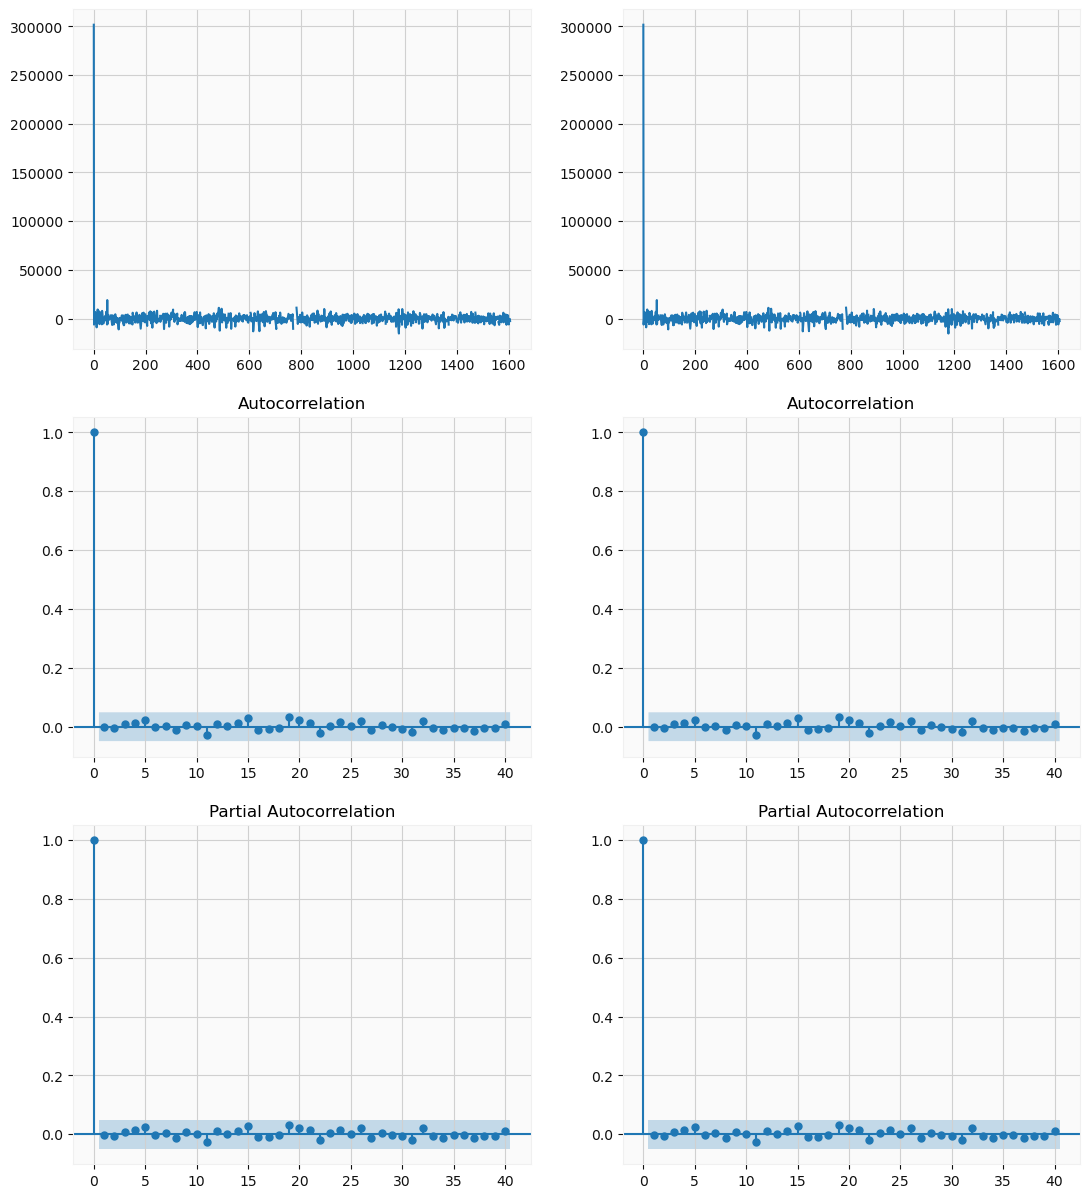

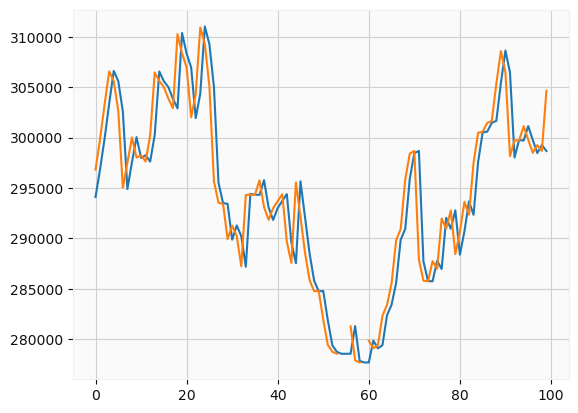

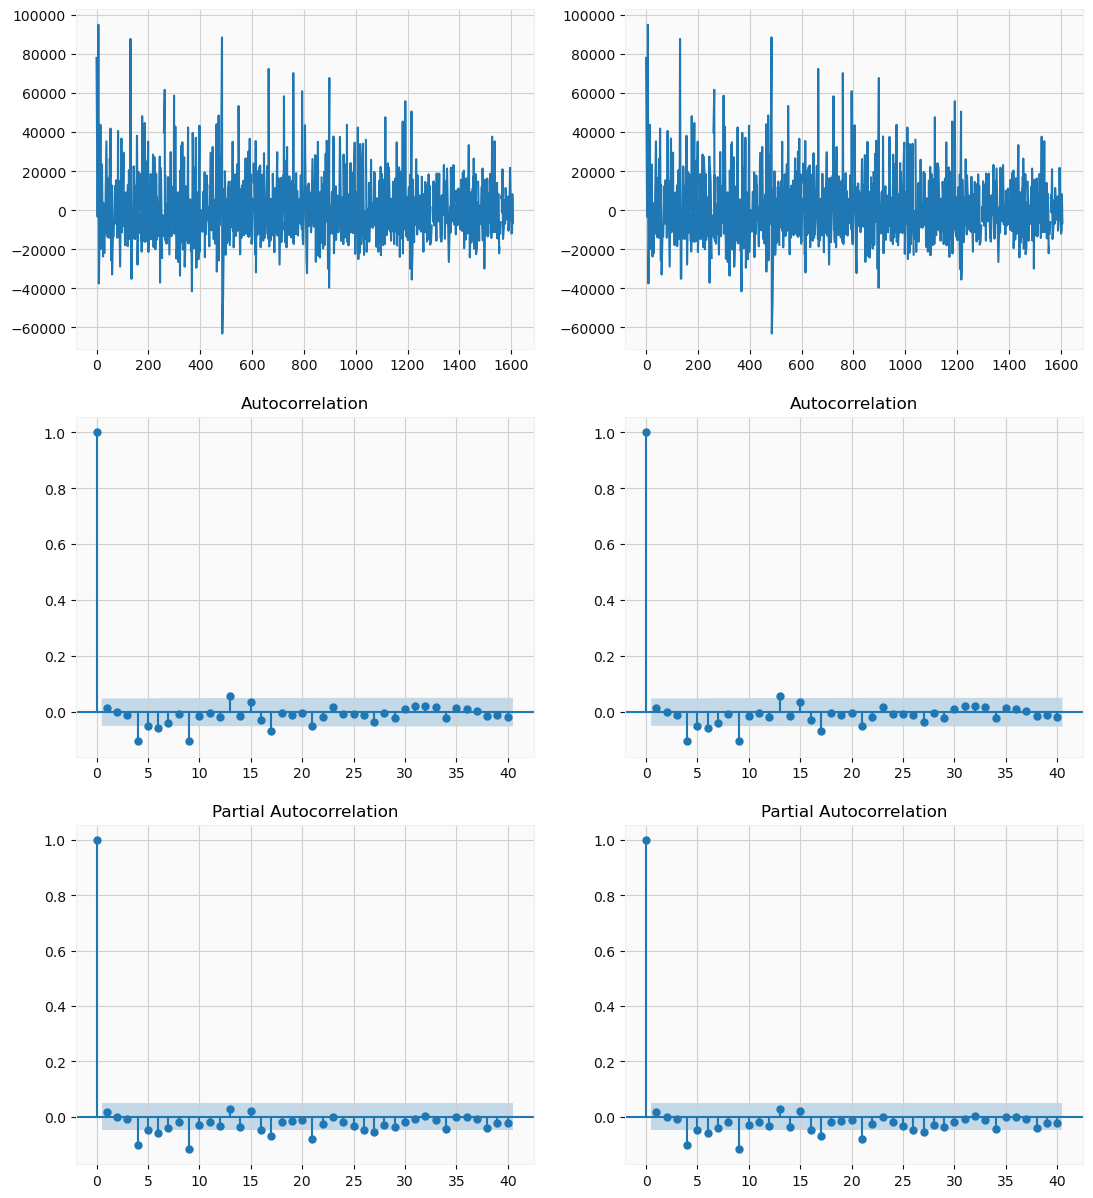

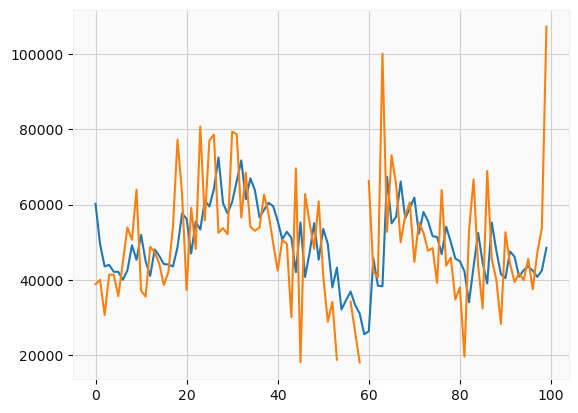

In [33]:
from statsmodels.tsa.arima.model import ARIMA

def make_model(series, pdq, pdqs, plot=False):
    model = ARIMA(series.to_numpy(),
                  order=pdq,
                  seasonal_order=pdqs,
                  missing='none')

    model_fit = model.fit()
    if plot:
        plt_ts_corr(pd.Series(model_fit.resid), pd.Series(model_fit.resid))
        plt.plot(model_fit.predict()[200:300])
        plt.plot(series.to_numpy()[200:300])
        plt.show()
    
    return model_fit

m2_oi_model = make_model(data_filled['Market2: Open_Interest'], (1,1,0), (0,0,0,0), plot=True)
m3_oi_model = make_model(data_filled['Market3: Open_Interest'], (1,1,0), (0,0,0,0))
m2_vol_model = make_model(data_filled['Market2: Volume'], (2,1,0), (2,0,0,3), plot=True)
m3_vol_model = make_model(data_filled['Market3: Volume'], (2,1,0), (2,0,0,3))

#### Observations
- Open Interest does ok with AR(1)
-It seems SARIMA(p, d, q)x(P, D, Q, s) model cannot entirely capture varied seasonal changes (ACF of residuals) in Volume series. We may revisit this later, but current model is good enough to fill missing volume datapoints

In [34]:
# Fill Volume and Open Interest by the model prediction/forecast
def fill_from_model(series, model):
    prediction = pd.Series(model.predict(), index=series.index)
    new = series.fillna(prediction, inplace=True)

cols = ['Market2: Open_Interest', 'Market3: Open_Interest',
        'Market2: Volume', 'Market3: Volume']
models = [m2_oi_model, m3_oi_model,
          m2_vol_model, m3_vol_model]
for i, col in enumerate(cols):
    fill_from_model(data_filled[col], models[i])
    
# Drop any nan rows
data_filled.dropna(inplace=True)

print('\nPercentage of data missing: \n')
perc_null = data_filled.isnull().sum() / data.count() * 100
print(perc_null.map('{:,.2f}%'.format))


Percentage of data missing: 

Market1: Close            0.00%
Market1: High             0.00%
Market1: Low              0.00%
Market1: Open             0.00%
Market2: Close            0.00%
Market2: High             0.00%
Market2: Low              0.00%
Market2: Open             0.00%
Market2: Open_Interest    0.00%
Market2: Volume           0.00%
Market3: Close            0.00%
Market3: High             0.00%
Market3: Low              0.00%
Market3: Open             0.00%
Market3: Open_Interest    0.00%
Market3: Volume           0.00%
dtype: object


### Conclusion
- We got dataset into great shape while dropping only 3 rows
- Extremely high collinearity may proove most of dataset redundand
- Possibly SARIMAX models can make use of M1, M3 data with M2 forecasting

### Feature engineering
- Add label whether day open-open move was bullish or bearish (1 / 0)

In [35]:
data_filled['Market1: Direction'] = (data_filled['Market1: Close']-data_filled['Market1: Open']).map(lambda x: 0 if x<0 else 1)
data_filled['Market2: Direction'] = (data_filled['Market2: Close']-data_filled['Market2: Open']).map(lambda x: 0 if x<0 else 1)
data_filled['Market3: Direction'] = (data_filled['Market3: Close']-data_filled['Market3: Open']).map(lambda x: 0 if x<0 else 1)

In [36]:
data_filled.to_csv('Dataset_tidy.csv')